# Objetivo

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, estudiando el historial clínico, cuales de ellos volverán a ser readmitidos al hospital por problemas con la diabetes.

Los datos fueron obtenidos de la página de UC Irvine Machine Learning Repository.
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

## Cargar librerías

In [193]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import statsmodels.api as sm
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import  *
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans

/home/eduardo/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Lectura de datos

In [35]:
p = '../../'

In [156]:
admission_source = pd.read_csv(p+'admission_source_id.csv')
admission_type = pd.read_csv(p+'admission_type_id.csv')
diabetes_what = pd.read_csv(p+'diabetic_data.csv')
discharge_disposition = pd.read_csv(p+'discharge_disposition_id.csv')
ids_mapping = pd.read_csv(p+'IDs_mapping.csv')

In [150]:
print(diabetes_.head())
print(admission_source.head())
print(admission_type.head())
print(discharge_disposition.head())

IndexError: index 50 is out of bounds for axis 0 with size 50

* Nos damos cuenta que diabetes es el conjunto principal y que los demás con códigos para ciertos atributos: los debemos sustituir

In [38]:
ids_meanings = [[admission_source, 'admission_source_id'],
                [admission_type, 'admission_type_id'],
                [discharge_disposition, 'discharge_disposition_id']]

for element in ids_meanings:
    diabetes =  diabetes.merge(element[0], on=element[1], how='left')
    diabetes = diabetes.drop(element[1], axis=1).rename(
        columns={'description':element[1][:-3]})

* Se estudian las dimensiones del dataset

In [39]:
num_rows = len(diabetes)
num_cols = len(diabetes.columns)
print("Este dataset tienen {0} registros y {1} columnas".format(num_rows, num_cols))

Este dataset tienen 101766 registros y 50 columnas


* Se estudia dataset resultante para determinar cuál será la variable objetivo

In [40]:
list(diabetes)

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'admission_source',
 'admission_type',
 'discharge_disposition']

#### se ve que la variable objetivo es la columna llamada 'readmitted'

* Se estudia el balanceo del dataset

In [158]:
diabetes.readmitted.value_counts()

0    44456
1    38690
Name: readmitted, dtype: int64

## Data Wrangling

* cambiar los nombres de las columnas con tal de evitar posibles errores futuros: todos los nombres en minúscular y sin signos a parte de '_'

In [42]:
diabetes = diabetes.rename(columns=lambda name: re.sub('\W', '_', name.strip()).lower())

* estudiar el formato de las variables y ver cuáles se deberían modificar

In [43]:
diabetes.dtypes

encounter_id                int64 
patient_nbr                 int64 
race                        object
gender                      object
age                         object
weight                      object
time_in_hospital            int64 
payer_code                  object
medical_specialty           object
num_lab_procedures          int64 
num_procedures              int64 
num_medications             int64 
number_outpatient           int64 
number_emergency            int64 
number_inpatient            int64 
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            int64 
max_glu_serum               object
a1cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

* las variables 'encounter_id' y 'patient_nbr' deberían ser tipo string --> no aportan información numérica

In [44]:
for column in ['encounter_id', 'patient_nbr']:
    diabetes[column] = diabetes[column].astype(str)

* Creamos listas con las variables para ver cuáles no se deben modificar (fixed_variables), cuáles se deberían pasar a dummy (dummy_variables) y cuáles se deberían pasar a binarias (binary_columns)

In [45]:
fixed_variables = ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_1', 'diag_2', 'diag_3']
dummy_variables = ['race', 'gender', 'payer_code', 'medical_specialty', 'admission_source', 'admission_type', 'discharge_disposition']
binary_columns = ['change', 'diabetesmed', 'readmitted']

* empezamos estudiando las variables binarias: ver primera si contienen nulos

In [171]:
diabetes.isnull().count()

encounter_id                                                                                                                       83146
patient_nbr                                                                                                                        83146
age                                                                                                                                83146
time_in_hospital                                                                                                                   83146
num_lab_procedures                                                                                                                 83146
num_procedures                                                                                                                     83146
num_medications                                                                                                                    83146
number_outpatient                        

In [159]:
print(len(diabetes[pd.isnull(diabetes.change)]))
print(len(diabetes[pd.isnull(diabetes.diabetesmed)]))
print(len(diabetes[pd.isnull(diabetes.readmitted)]))

0
0
0


* al no tener, procedemos directamente a convertirlas en variables binarias y una vez arregladas las añadimos a la lista de 'fixed_variables'

In [47]:
for column in binary_columns:
    diabetes[column] = diabetes[column].map(lambda value: 0 
                                            if value.lower().strip() == 'no' else 1)
    
fixed_variables += ['change', 'diabetesmed', 'readmitted']

* Creamos una lista con las variables para arreglar ('variables_to_fix') donde se encuentren todas excepto las que ya están en 'fixed_variables' y las que se convertirán en dummy

In [48]:
variables_to_fix = [column for column in list(diabetes) 
                    if column not in fixed_variables + dummy_variables]

* de entre éstas se encuentran 'age' y 'weight' que son categóricas ordinales. Creamos diccionario con valores para convertirlas en numéricas. Las añadimos a 'fixed_variables' y recalculamos 'variables_to_fix'

In [49]:
print(diabetes.age.value_counts())

def age_dict(age_range):
    age_values = {'[0-10)': 0, 
                  '[10-20)': 1, 
                  '[20-30)': 2, 
                  '[30-40)': 3, 
                  '[40-50)': 4, 
                  '[50-60)': 5, 
                  '[60-70)': 6,
                  '[70-80)': 7, 
                  '[80-90)': 8, 
                  '[90-100)': 9}
    if age_range in age_values.keys():
        value = age_values[age_range]
    else: value = 3
    
    return value

print(diabetes.weight.value_counts())

def weight_dict(weight_range):
    weight_values = {'[0-25)': 0, 
                     '[25-50)': 1, 
                     '[50-75)': 2, 
                     '[75-100)': 3, 
                     '[100-125)': 4, 
                     '[125-150)': 5,
                     '[150-175)': 6,
                     '[175-200)': 7, 
                     '>200': 8}
    if weight_range in weight_values.keys():
        value = weight_values[weight_range]
    else: value = np.nan
    return value

diabetes.age = diabetes.age.map(age_dict)
diabetes.weight = diabetes.weight.map(weight_dict)

fixed_variables += ['age', 'weight']
variables_to_fix = [column for column in list(diabetes) 
                    if column not in fixed_variables + dummy_variables]

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)     9685 
[30-40)     3775 
[90-100)    2793 
[20-30)     1657 
[10-20)     691  
[0-10)      161  
Name: age, dtype: int64
?            98569
[75-100)     1336 
[50-75)      897  
[100-125)    625  
[125-150)    145  
[25-50)      97   
[0-25)       48   
[150-175)    35   
[175-200)    11   
>200         3    
Name: weight, dtype: int64


* también se aprecia que 'max_glu_serum' y 'a1cresult' son categóricas ordinales. Se repite el mismo proceso que antes con 'weight' y 'age'

In [50]:
print(diabetes.max_glu_serum.value_counts())

def max_glu_serum_dict(max_glu_serum_range):
    max_glu_serum_values = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
    if max_glu_serum_range in max_glu_serum_values.keys():
        value = max_glu_serum_values[max_glu_serum_range]
    else: value = np.nan
    return value

print(diabetes.a1cresult.value_counts())

def a1cresult_dict(a1cresult_range):
    a1cresult_values = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
    if a1cresult_range in a1cresult_values.keys():
        value = a1cresult_values[a1cresult_range]
    else: value = np.nan
    return value

diabetes.max_glu_serum = diabetes.max_glu_serum.map(max_glu_serum_dict)
diabetes.a1cresult = diabetes.a1cresult.map(a1cresult_dict)

fixed_variables += ['max_glu_serum', 'a1cresult']
variables_to_fix = [column for column in list(diabetes) 
                    if column not in fixed_variables + dummy_variables]



None    96420
Norm    2597 
>200    1485 
>300    1264 
Name: max_glu_serum, dtype: int64
None    84748
>8      8216 
Norm    4990 
>7      3812 
Name: a1cresult, dtype: int64


* Se estudian el resto de variables en 'variables_to_fix'

In [51]:
diabetes[variables_to_fix].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
2,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
4,No,No,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No


* se aprecia que todas la variables restantes en variables_to_fix se comportan igual: creamos un dictionary

In [52]:
def usage_dict(usage_range):
    usage_values = {'No':0, 'Down':1, 'Steady':2, 'Up':3}
    if usage_range in usage_values.keys():
        value = usage_values[usage_range]
    else: value = np.nan
    return value

In [53]:
for variable in variables_to_fix:
    diabetes[variable] = diabetes[variable].map(usage_dict)

In [54]:
diabetes.dtypes

encounter_id                object 
patient_nbr                 object 
race                        object 
gender                      object 
age                         int64  
weight                      float64
time_in_hospital            int64  
payer_code                  object 
medical_specialty           object 
num_lab_procedures          int64  
num_procedures              int64  
num_medications             int64  
number_outpatient           int64  
number_emergency            int64  
number_inpatient            int64  
diag_1                      object 
diag_2                      object 
diag_3                      object 
number_diagnoses            int64  
max_glu_serum               int64  
a1cresult                   int64  
metformin                   int64  
repaglinide                 int64  
nateglinide                 int64  
chlorpropamide              int64  
glimepiride                 int64  
acetohexamide               int64  
glipizide                   

* ahora las variables sí están en su formato adecuado. Las únicas que siguen siendo de tipo string son aquellas variables categóricas no ordinales

### estudiar si hay registros repetidos

In [55]:
num_rows = len(diabetes)
diabetes = diabetes.drop_duplicates(
num_rows_clean = len(diabetes)
print("En este dataset había {} registros repetidos".format(num_rows - num_rows_clean))

SyntaxError: invalid syntax (<ipython-input-55-47cc01e65412>, line 4)

### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

* si se trata de variables continuas --> se estudia la varianza de las columnas

In [57]:
variables_numericas = list(diabetes.dtypes[diabetes.dtypes != 'object'].index)
variables_string = list(diabetes.dtypes[diabetes.dtypes == 'object'].index)

SyntaxError: invalid syntax (<ipython-input-57-bd6cdfc7a929>, line 1)

In [58]:
variances = diabetes[variables_numericas].var(axis=0)
unique_values = []
for element in variables_numericas:
    unique_values.append(len(diabetes[element].unique()))
    
data = []
for variable, variance, unique_values in zip(variables_numericas, variances, unique_values):
    data.append([variable, variance, unique_values])
    
variance_study = pd.DataFrame(data, columns=['variable', 'variance', 'unique_values']).sort_values(['unique_values','variance'], ascending=[True, True])
variance_study

,variable,variance,unique_values
27,examide,0.000000,1
28,citoglipton,0.000000,1
34,metformin_pioglitazone,0.000039,2
32,glimepiride_pioglitazone,0.000039,2
17,acetohexamide,0.000039,2
33,metformin_rosiglitazone,0.000079,2
25,troglitazone,0.000118,2
31,glipizide_metformin,0.000511,2
20,tolbutamide,0.000904,2
36,diabetesmed,0.177085,2


* eliminamos todas las variables cuya varianza está por debajo de 0.001

In [59]:
columns_to_delete = variance_study[variance_study.variance < 0.001].variable.tolist()

diabetes.drop(columns_to_delete, axis=1, inplace=True)

* si se trata de variables categóricas --> se estudia número apariciones de cada categoría

In [60]:
for column in variables_string:
    print(column+'\n')
    print(diabetes[column].value_counts())
    print('\n')

encounter_id

84117318     1
165777030    1
133277130    1
94910688     1
70399098     1
89331396     1
269714274    1
187298964    1
219234672    1
272813262    1
19627344     1
161617722    1
150512088    1
105013644    1
137703006    1
279689586    1
212197506    1
111017010    1
154004616    1
199658832    1
274537656    1
50849394     1
338378576    1
173796618    1
164304228    1
281986794    1
58340262     1
60998178     1
201565770    1
134191032    1
            ..
220534254    1
53626350     1
337179230    1
147586854    1
168337386    1
158728110    1
122051376    1
49480428     1
44482764     1
182062302    1
247185102    1
124585770    1
173721174    1
77663802     1
176375298    1
285776238    1
131280306    1
83724528     1
157753524    1
186452148    1
256470492    1
137027526    1
217911114    1
63749598     1
102253854    1
73803540     1
166290612    1
345496442    1
137933250    1
284714952    1
Name: encounter_id, Length: 101766, dtype: int64


patient_nbr

8878589

### estudio de nulos en el dataset --> hay tanto nulos como '?' que se toman como nulos

In [61]:
nulls_info = []
num_rows = len(diabetes)

for column in list(diabetes):
    
    if str(diabetes.dtypes[column]) == 'object':
        number_nulls = len(diabetes[(pd.isnull(diabetes[column]))|(diabetes[column] == '?')])
    else: number_nulls = len(diabetes[pd.isnull(diabetes[column])])
    
    nulls_info.append([column,number_nulls*100/num_rows])    
    
nulls_info_df = pd.DataFrame(nulls_info, columns=['variable', 'percentage_nulls']).sort_values('percentage_nulls',ascending=False)
nulls_info_df

,variable,percentage_nulls
5,weight,96.858479
8,medical_specialty,49.082208
7,payer_code,39.557416
2,race,2.233555
17,diag_3,1.398306
16,diag_2,0.351787
15,diag_1,0.020636
0,encounter_id,0.000000
31,miglitol,0.000000
26,glipizide,0.000000


* Estudiando el porcentaje de nulos por variables, se decide eliminar las variables: 'weight', 'medical_specialty', 'payer_code'.


* Tratándose de la diabetes, 'weight' podría ser MUY importante: hablar con el 'data owner' para informarle de la mala calidad de esta variable para que mejoren su almacenamiento

In [62]:
limit_nulls = 15

columns_toomany_nulls = nulls_info_df[nulls_info_df.percentage_nulls >= limit_nulls].variable.tolist()
diabetes.drop(columns_toomany_nulls, axis=1, inplace=True)

columns_with_nulls = nulls_info_df[(nulls_info_df.percentage_nulls < limit_nulls) & 
                                   (nulls_info_df.percentage_nulls > 0)].variable.tolist()

for column in columns_with_nulls:
    diabetes = diabetes[diabetes[column] != '?']

num_rows_final = len(diabetes)

print('\nAfter removing all empty values, have lost a total of {0} registers, which represent a {1}% of the initial registers.'.format(num_rows - num_rows_final, (num_rows-num_rows_final)*100/float(num_rows)))


After removing all empty values, have lost a total of 3713 registers, which represent a 3.6485663188098187% of the initial registers.


### estudiamos los outliers. Primero ver la distribución de los datos. Si la distribución es normal, podemos utilizar desviaciones típicas para determinar los outliers

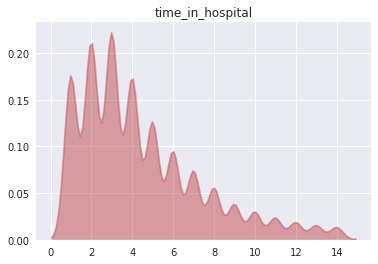

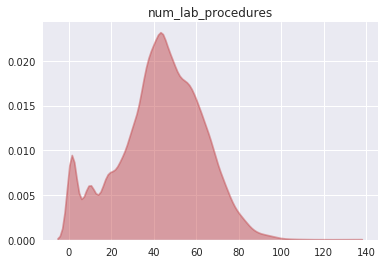

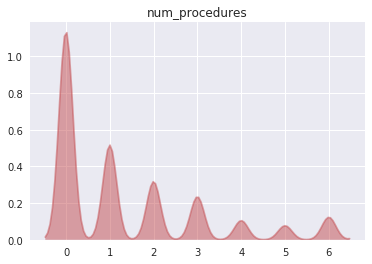

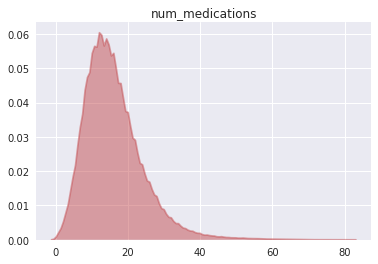

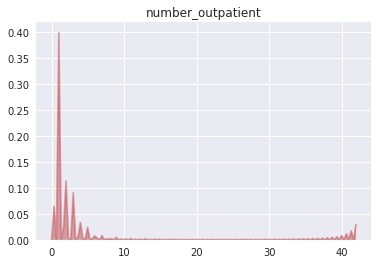

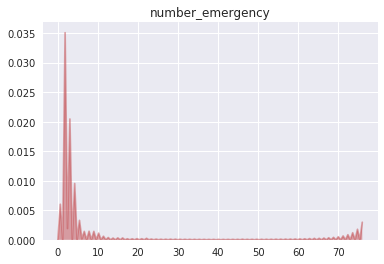

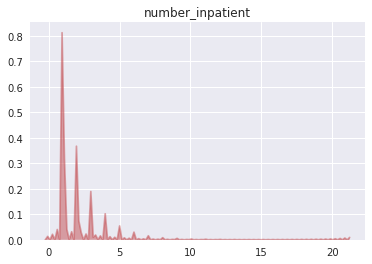

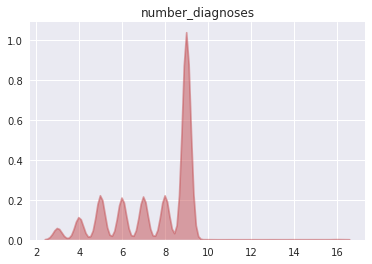

In [63]:
#listado de variable numéricas: sólo buscaremos outliers para éstas

numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

for index, element in enumerate(numerical_features):
    plt.figure(index)
    ax = sns.kdeplot(diabetes[element].tolist(), shade=True, color="r", alpha=0.5)
    ax.set_title(element)

* tras estas gráficas se aprecia que, aunque todas las variables tengan valor númerico, algunas toman valores discretos y no tienen sentido sus distribuciones tal como se han pintado. Otra manera de estudiar la 'normalidad' de los datos es mediante el test de Kolmogorov-Smirnov.

### vemos que ninguna de las variables tiene una distribución normal: sería mejor opción, al ser pocas, estudiar sus distribuciones y decidir donde poner el corte de outliers. Nos encontramos sólo con los tres casos siguientes:

In [65]:
variables_outliers = [['num_lab_procedures', 110], ['num_medications', 65], ['number_diagnoses', 14]]

for element in variables_outliers:
    initial = len(diabetes)
    diabetes = diabetes[diabetes[element[0]]<element[1]]
    final = len(diabetes)
    print("En la variable {0} se encontraban {1} outliers".format(element[0], initial-final))

En la variable num_lab_procedures se encontraban 14 outliers
En la variable num_medications se encontraban 46 outliers
En la variable number_diagnoses se encontraban 54 outliers


* Sólo faltan las variables dummy. Como las categorías que tomas se convertirán en los nombres de las columnas, así que limpiamos sus nombres para evitar futuras complicaciones: minúscula, sin tildes, y sólamente con guión bajo como símbolo no alfanumérica. 


* Nos damos cuenta que se usa '?' para NaN


* Limpiamos sus categorías, estudiamos las variables como tal y ya más adelante se crearán dummies

* Vemos que el proceso de estudio se debe hacer al pricipio: nos hubiéramos ahorrado el diccionario para modificar la variable 'weight' y al eliminar variables que queríamos pasar a 'dummy' ahorramos trabajo. Comprobemos ahora cuantas quedan para pasar a 'dummy'

In [66]:
dummy_variables = [element for element in dummy_variables if element in list(diabetes)]
print(len(dummy_variables))
dummy_variables

5


['race',
 'gender',
 'admission_source',
 'admission_type',
 'discharge_disposition']

In [67]:
for column in dummy_variables:
    diabetes[column] = diabetes[column].map(lambda value: value if isinstance(value, str) == False else np.nan if value.strip()=='?' else re.sub('\W', '_', value.strip()).lower())

* Estudiar los valores de cada variable a pasar a dummy para saber qué categorías están disponibles


In [68]:
for element in dummy_variables:
    print(diabetes[element].value_counts())
    print('\n')

caucasian          74991
africanamerican    18858
hispanic           1981 
other              1484 
asian              625  
Name: race, dtype: int64


female             52783
male               45155
unknown_invalid    1    
Name: gender, dtype: int64


emergency_room                                               55879
physician_referral                                           28322
none                                                         6597 
transfer_from_a_hospital                                     2942 
transfer_from_another_health_care_facility                   1893 
clinic_referral                                              1031 
transfer_from_a_skilled_nursing_facility__snf_               846  
hmo_referral                                                 179  
not_mapped                                                   160  
not_available                                                49   
court_law_enforcement                                        15   
transfe

* Estudiando las categorías existentes, filtramos por valores que indican 'nulos'

In [69]:
initial = len(diabetes)
diabetes = diabetes[diabetes.gender != 'unknown_invalid']
diabetes = diabetes[(diabetes.admission_source != 'not_mapped')&(diabetes.admission_source != 'not_available')&(diabetes.admission_source != 'none')]
diabetes = diabetes[(diabetes.admission_type != 'not_mapped')&(diabetes.admission_type != 'not_available')&(diabetes.admission_type != 'none')]
diabetes = diabetes[(diabetes.discharge_disposition != 'not_mapped')&(diabetes.discharge_disposition != 'none')]
final = len(diabetes)

print('After filtering undesired values for categorical values, {0} registers haven been removed; a {1}% of the rows'.format(initial-final, (initial-final)*100/float(initial)))

After filtering undesired values for categorical values, 14793 registers haven been removed; a 15.104299615066521% of the rows


* Ahora ya sí procedemos a la creación de las variables 

In [70]:
diabetes = pd.get_dummies(diabetes, columns=dummy_variables)

* Ahora todas las variables deberían ser de tipo numérico. Veamos si es así. En caso que no lo sea, estudiar cuáles son y por qué

In [71]:
print(diabetes.dtypes.value_counts())

string_variables = [index for index, element in enumerate(diabetes.dtypes) if str(element) == 'object']
wrong_format = diabetes.iloc[:,string_variables]
wrong_format

uint8     46
int64     28
object    5 
dtype: int64


,encounter_id,patient_nbr,diag_1,diag_2,diag_3
1,149190,55629189,276,250.01,255
2,64410,86047875,648,250,V27
3,500364,82442376,8,250.43,403
4,16680,42519267,197,157,250
5,35754,82637451,414,411,250
6,55842,84259809,414,411,V45
7,63768,114882984,428,492,250
8,12522,48330783,398,427,38
9,15738,63555939,434,198,486
10,28236,89869032,250.7,403,996


* hace falta arreglar los casos en que se toma el valor (V__) ya que es erróneo. Se modificarán a 0 y se cambiará formato
de la variable:

In [72]:
def fix_floats(value):
    try:
        if pd.isnull(value):
            return 0
        isinstance(float(value), float)
        return float(value)
    except ValueError:
        return 0

for element in list(wrong_format):
    diabetes[element] = diabetes[element].map(fix_floats)
    diabetes[element] = diabetes[element].astype('float')

### antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

* se crea variable con conteo de cuántas veces se ha readmitido a un paciente --> para emular realidad cuando lleguen nuevos pacientes, será necesario, en caso que alguna vez sí haya sido readmitido, restar 1. Esto es, porque cuando lleguen nuevos datos solamente conoceremos información del pasado, y querremos predecir si será o no readmitido.

In [73]:
times_admitted = diabetes.groupby(by=['patient_nbr'], as_index=False).count()[['patient_nbr','encounter_id']].rename(columns={'encounter_id':'number_times_admitted'})
diabetes = diabetes.merge(times_admitted, on='patient_nbr', how='left')

diabetes['number_times_admitted'] = diabetes['number_times_admitted'].map(lambda value: value-1 if value != 0. else value)

* estudiar cómo de balanceado está el dataset de entrada

In [74]:
readmitted_balance = pd.DataFrame(diabetes.groupby('readmitted').count()['encounter_id']).reset_index().rename(columns={'encounter_id':'readmitted_number'})
readmitted_balance['readmitted_percent'] = readmitted_balance.readmitted_number*100/num_rows_final
readmitted_balance

,readmitted,readmitted_number,readmitted_percent
0,0,44456,45.338745
1,1,38690,39.458252


# Exploratory Data Analysis

### estudiamos las correlaciones, pero al hacerlo, no incorporamos la variable objetivo

* Creamos la matriz de correlaciones

In [75]:
variables_to_ignore = ['encounter_id','patient_nbr','readmitted']
variables_study = [element for element in list(diabetes) if element not in variables_to_ignore]

correlation_matrix = diabetes[variables_study].corr(method='spearman')

* pintamos sus resultados

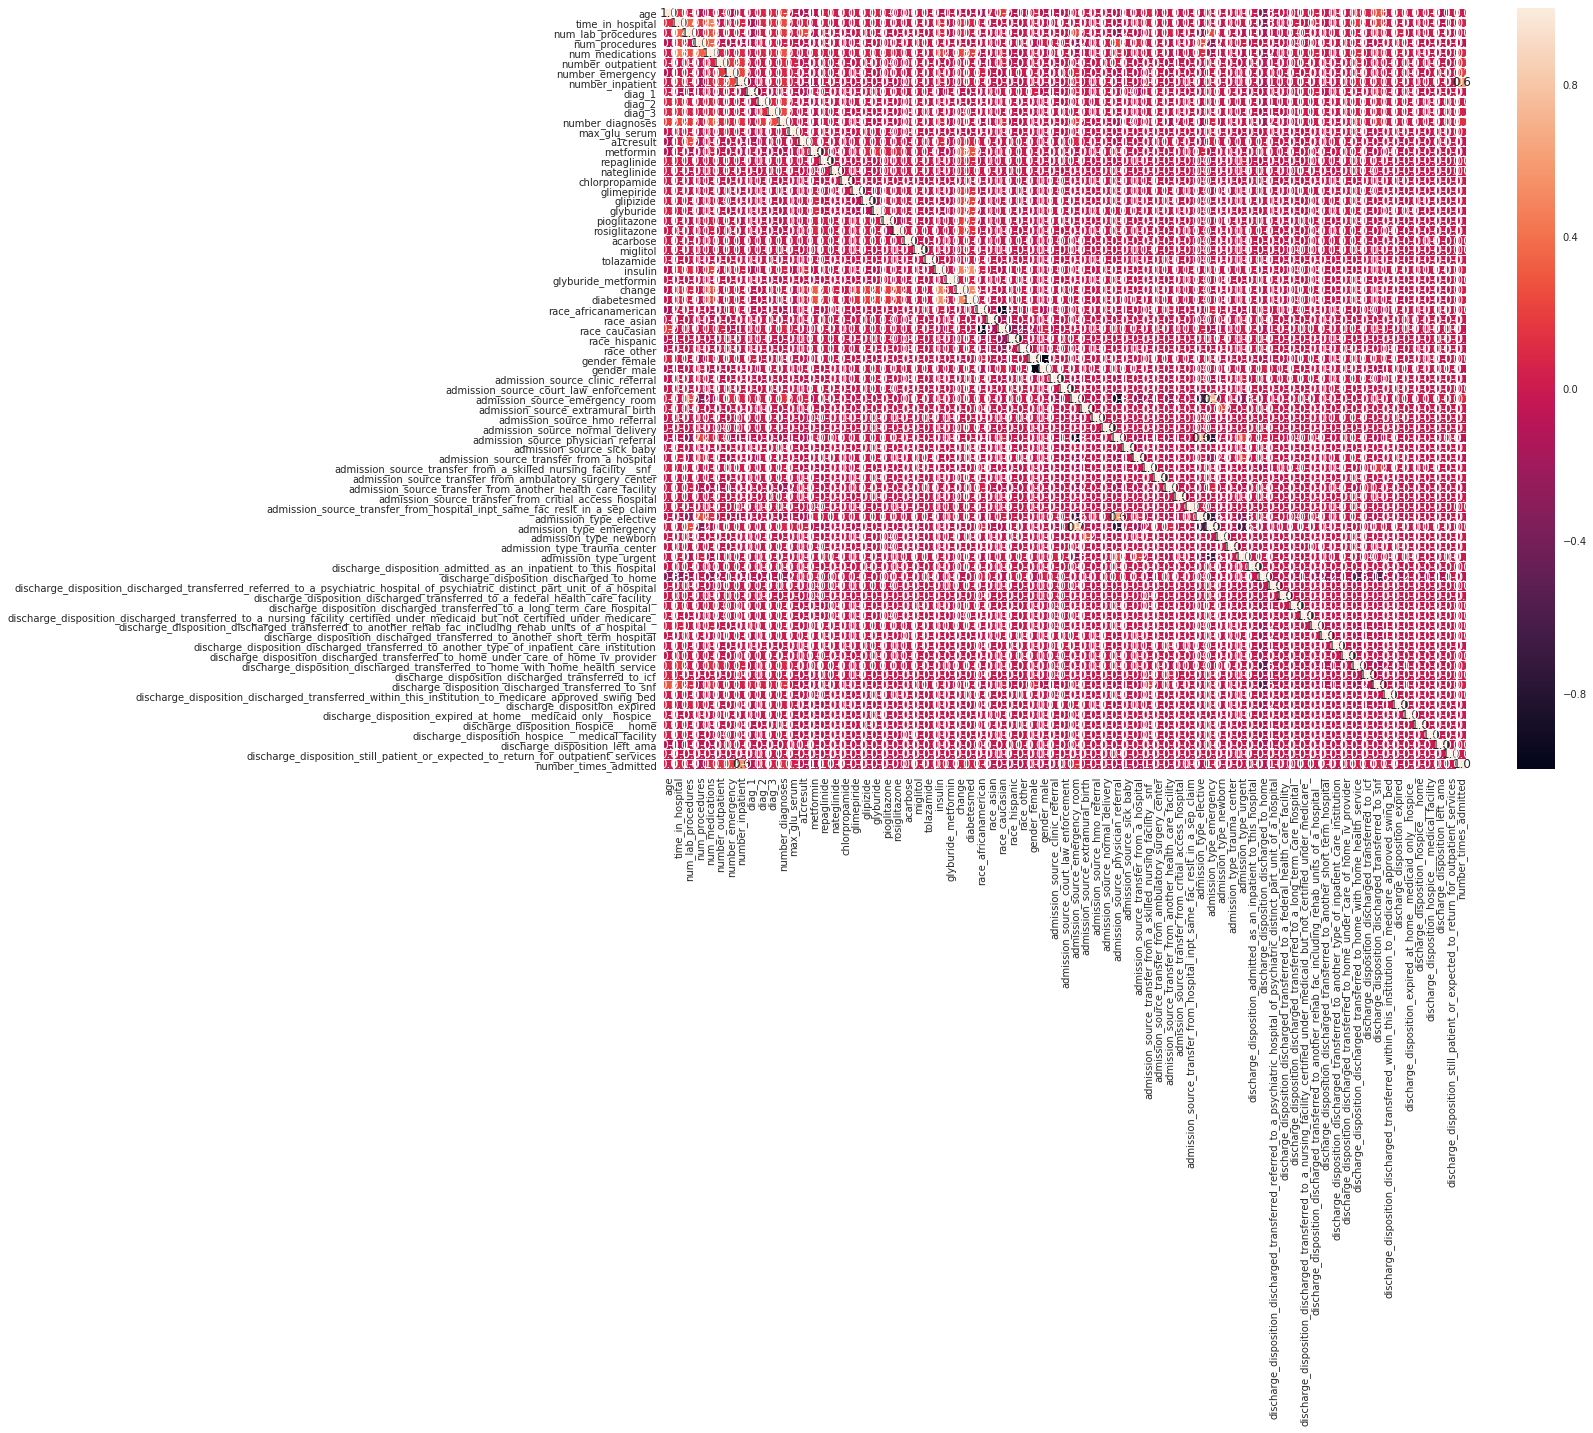

In [76]:
figure_size = (18, 14)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(correlation_matrix, xticklabels=list(correlation_matrix), yticklabels=list(correlation_matrix),
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax)

* una vez se tiene la matriz, se determina valor a partir del cual se considera que dos variables están correlacionadas y se estudian los resultados de la matriz

In [77]:
num_variables = len(correlation_matrix)
correlation_value = 0.7
correlated_variables = []

for row in range(1,num_variables):
    for col in range(0,row):
        if abs(correlation_matrix.iloc[row,col]) >= correlation_value:
            print('La variable {0} esta correlacionada con la variable {1} con un factor de {2}'.format(list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]))
            correlated_variables.append([list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]])
        

La variable race_caucasian esta correlacionada con la variable race_africanamerican con un factor de -0.8911721310638949
La variable gender_male esta correlacionada con la variable gender_female con un factor de -1.0
La variable admission_source_physician_referral esta correlacionada con la variable admission_source_emergency_room con un factor de -0.8493274766382674
La variable admission_type_emergency esta correlacionada con la variable admission_source_emergency_room con un factor de 0.7185378014662405
La variable admission_type_emergency esta correlacionada con la variable admission_source_physician_referral con un factor de -0.7056207422155205


* estudiando los resultados, nos damos cuenta que queremos mantener caucasian y africanamerican: es un efecto de los datos. Eliminar male o female está bien porque es binaria: misma información almacenada en tan solo una de las variables


In [78]:
correlated_variables = correlated_variables[1:]
correlated_variables = sorted(correlated_variables, key=lambda value: abs(value[-1]), reverse=True)
correlated_variables

[['gender_male', 'gender_female', -1.0],
 ['admission_source_physician_referral',
  'admission_source_emergency_room',
  -0.84932747663826735],
 ['admission_type_emergency',
  'admission_source_emergency_room',
  0.71853780146624047],
 ['admission_type_emergency',
  'admission_source_physician_referral',
  -0.70562074221552051]]

### distintos métodos para escoger variables a mantener

#### 1r: capacidad discriminante: primero separamos el dataset para cuando toma 0 y 1 la variable objetivo

In [81]:
diabetes_0 = diabetes[diabetes.readmitted==0]
diabetes_1 = diabetes[diabetes.readmitted==1]

* procedemos a hacer las gráficas para las variables que están correlaciodas con tal de estudiar su capacidad discriminante

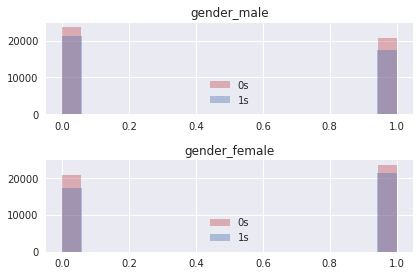

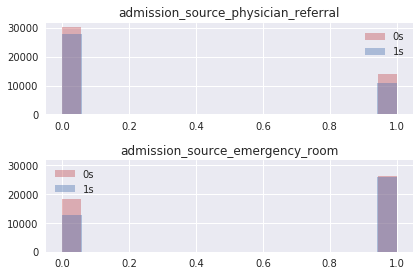

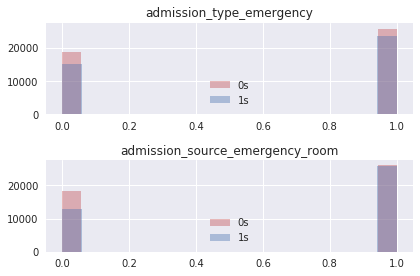

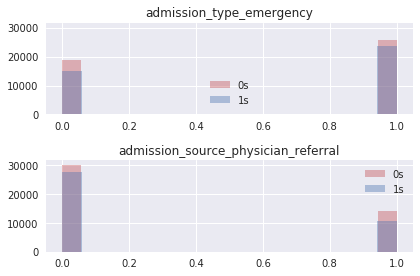

In [84]:
for element in correlated_variables:
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)
    sns.distplot(diabetes_0[element[0]].tolist(), color="r", kde=False, label='0s', ax=ax1)
    sns.distplot(diabetes_1[element[0]].tolist(), color="b", kde=False, label='1s', ax=ax1)
    ax1.legend()
    ax1.set_title(element[0])

    sns.distplot(diabetes_0[element[1]].tolist(), color="r", kde=False, label='0s', ax=ax2)
    sns.distplot(diabetes_1[element[1]].tolist(), color="b", kde=False, label='1s', ax=ax2)
    ax2.legend()
    ax2.set_title(element[1])

    fig.tight_layout()

In [191]:
df = pd.read_csv('../../iris.csv')

In [192]:
df.head()

IndexError: index 5 is out of bounds for axis 0 with size 5

KeyError: 0

* ante estos resultados no es fácil decidir:

- Por lo que hace entre 'gender_male' y 'gender_female' no se aprecian diferencias. 

- Parece que deberíamos quedarnos con 'admission_source_emergency_room': diferencia mejor entre 0s y 1s.

- Difícil ver la diferencia: ¿quizás mantener admission_source_physician_referral?

### 2o: correlación con variable objetivo

In [85]:
columns_to_delete_correlation_target = []
for element in correlated_variables:
    if element[0] not in list(diabetes) or element[1] not in list(diabetes):
        break
    else:
        first = diabetes.readmitted.corr(diabetes[element[0]], method='spearman')
        second = diabetes.readmitted.corr(diabetes[element[1]], method='spearman')
        if abs(first) > abs(second):
            print('La variable {0} esta mas correlacionada con la variable objetiva "readmitted"'.format(element[0]))
            columns_to_delete_correlation_target.append(element[1])
        else: 
            print('La variable {0} esta mas correlacionada con la variable objetiva "readmitted"'.format(element[1]))
            columns_to_delete_correlation_target.append(element[0])

columns_to_delete_correlation_target = list(set(columns_to_delete_correlation_target))
diabetes.drop(columns_to_delete_correlation_target, axis=1, inplace=True)

La variable gender_female esta mas correlacionada con la variable objetiva "readmitted"
La variable admission_source_emergency_room esta mas correlacionada con la variable objetiva "readmitted"
La variable admission_source_emergency_room esta mas correlacionada con la variable objetiva "readmitted"
La variable admission_source_physician_referral esta mas correlacionada con la variable objetiva "readmitted"


## Modelado

* volvemos a calcular las dimensiones de nuestro dataset tras todas las operaciones anteriores

In [86]:
num_rows = len(diabetes)
num_cols = len(diabetes.columns)
print("Este dataset tienen {0} registros y {1} columnas".format(num_rows, num_cols))

Este dataset tienen 83146 registros y 77 columnas


### ya se ha estudiado correlaciones entre pares de variables. Ahora toca hacer selección de variables: se hará con Random Forest (por ejemplo)

* Un random forest tiene un factor 'random': intentar evitarlo tal como se explica a continuación

In [87]:
number_seeds = 10
seed_value = 4
feature_importance_cumulative_value = 0.9

random.seed(seed_value)
random_seeds = []

while len(random_seeds) < number_seeds:
    random_seeds.append(random.randint(1,1000))
    random_seeds = list(set(random_seeds))

total_feature_seeds = []
for random_seed in random_seeds:
    target = 'readmitted'
    not_input = ['readmitted', 'patient_nbr', 'encounter_id']
    input_features = [column for column in list(diabetes) if column not in not_input]

    feature_selection = RandomForestClassifier(random_state = random_seed)
    feature_selection.fit(diabetes[input_features], diabetes[target])
    # display the relative importance of each attribute
    print(feature_selection.feature_importances_)
    
    feature_importance_data = sorted([[feature, importance] for feature, 
            importance in zip(input_features, feature_selection.feature_importances_)], 
           key=lambda value: value[-1], reverse=True)
    
    total_sum = 0
    elements_below_threshold = []
    for element in feature_importance_data:
        total_sum += element[1]
        if total_sum <= feature_importance_cumulative_value:
            elements_below_threshold.append(element)
        else: break
    total_feature_seeds.append(elements_below_threshold)

[  3.45969701e-02   4.09335658e-02   6.64971860e-02   2.78445342e-02
   5.75764497e-02   1.65959039e-02   1.30642433e-02   5.71696816e-02
   6.15613468e-02   6.01147159e-02   6.00535771e-02   2.90121778e-02
   5.24701154e-04   1.23322414e-02   1.07133983e-02   2.70905154e-03
   1.47107408e-03   2.04826885e-04   5.60770821e-03   9.21889015e-03
   8.05328555e-03   6.88023447e-03   5.62252591e-03   5.94858770e-04
   1.28826834e-04   4.94709865e-05   1.97386003e-02   1.37698013e-03
   9.67734105e-03   6.69522089e-03   7.03378152e-03   9.49865883e-04
   7.70644605e-03   1.98359032e-03   1.89452323e-03   1.45539864e-02
   1.51078425e-03   6.26012599e-06   8.54846586e-03   3.10740295e-07
   2.02974714e-04   7.90580090e-06   1.20939364e-06   2.60269757e-03
   1.00602817e-03   1.41634067e-06   2.35628574e-03   3.70972559e-05
   7.76740588e-06   5.81531475e-03   2.64055136e-05   4.30524789e-05
   8.78433107e-03   4.94183716e-05   9.00885238e-03   2.24508447e-04
   1.93935975e-06   8.22082648e-04

* Estudiamos los resultados para quedarnos solamente con aquellas variables que están presentes en todas las iteraciones
y creamos dataframe con información de variables elegidas y su importancia promedio

In [89]:
selected_features = [element[0] for element in Counter([item[0] for element in total_feature_seeds for item in element]).items() 
 if element[1] ==number_seeds]

features_dictionary = {}
for element in selected_features:
    features_dictionary[element] = []
    for results in total_feature_seeds:
        for item in results:
            if element == item[0]:
                features_dictionary[element].append(item[1])
    
feature_importance_data = []
for key, value in features_dictionary.items():
    feature_importance_data.append([key, np.mean(value)])
    
feature_importance_df = pd.DataFrame(data=feature_importance_data, columns=['feature', 'importance'])
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df

,feature,importance
3,number_times_admitted,0.277614
16,num_lab_procedures,0.064247
10,diag_1,0.060220
2,diag_2,0.059538
11,diag_3,0.058373
8,number_inpatient,0.057873
17,num_medications,0.056177
7,time_in_hospital,0.040862
1,age,0.033691
13,num_procedures,0.027953


* creamos lista con variables seleccionadas

In [90]:
selected_features = feature_importance_df.feature.tolist()

### estandarización de variables

In [91]:
diabetes_model = diabetes[selected_features]
min_max = MinMaxScaler()
min_max_model = min_max.fit(diabetes_model)
diabetes_model = min_max_model.transform(diabetes_model)

empezamos a modelar

#### ¿están balanceados nuestros datos después de todos los cambios hechos?

In [92]:
balancing = diabetes.groupby(by='readmitted', as_index=False)['diag_2'].count().rename(columns={'diag_2':'count'})

balancing['count:percentage'] = balancing['count']*100/num_rows
balancing

,readmitted,count,count:percentage
0,0,44456,53.467395
1,1,38690,46.532605


* ¡sí lo está! No deberemos hacer nada con oversampling ni undersampling

### creamos train y test para empezar a modelar

* creamos train y test

In [93]:
y = diabetes.readmitted

X_train, X_test, y_train, y_test = train_test_split(diabetes_model, y, train_size= 0.8, stratify = y )

### repasar métricas: en nuestro caso, como estamos interesados en evitar posibles complicaciones médicas, es recomendable buscar un modelo que detecte el mayor nombre posible de readmisiones aunque haga predicciones erróneas de más: en tal caso interesados en RECALL

## Algoritmos y evaluación

como vamos a probar distintos algoritmos, almacenemos los resultados en lista 'final_results' para luego poder crear dataframe y comparar los distintos resultados. Inicializamos la lista en cuestión

In [94]:
final_results = []

### Regresión Logística

In [95]:
lr = LogisticRegression(random_state = seed_value)

lr.fit(X_train, y_train)

predictions_lr = lr.predict(X_test)
prob_predictions_lr = lr.predict_proba(X_test)
cm_lr = confusion_matrix(y_test, predictions_lr)

recall_lr = recall_score(y_test, predictions_lr)
recall_lr

0.61643835616438358

* Pintamos matriz de confusión

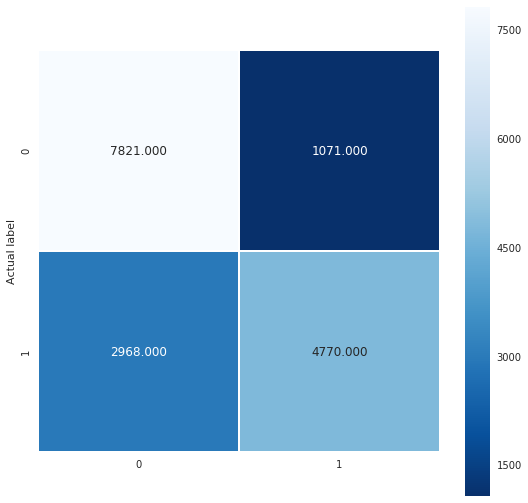

In [96]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_lr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

#### vemos que hay muchos FN (falsos negativos). ¿Cómo podemos mejorar este resultado? Jugando con el threshold

In [97]:
prob_predictions1 = [element[1] for element in prob_predictions_lr]

recall_precision_lr = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value > threshold else 0 for value in prob_predictions1]
    recall_precision_lr.append([threshold, recall_score(y_test, given_threshold), precision_score(y_test, given_threshold)])

recall_precision_lr

[[0.01, 1.0, 0.47269395235186318],
 [0.02, 1.0, 0.47280948307466697],
 [0.029999999999999999, 1.0, 0.47289616818431829],
 [0.040000000000000001, 1.0, 0.47295397591834237],
 [0.050000000000000003, 0.9998707676402171, 0.47292176039119804],
 [0.060000000000000005, 0.9998707676402171, 0.47295066935631763],
 [0.069999999999999993, 0.9998707676402171, 0.47295066935631763],
 [0.080000000000000002, 0.99974153528043419, 0.47291844968822594],
 [0.089999999999999997, 0.99974153528043419, 0.4729473619856942],
 [0.099999999999999992, 0.99961230292065129, 0.47291513817559305],
 [0.11, 0.99961230292065129, 0.47294405380617549],
 [0.12, 0.99948307056086849, 0.47291182585300234],
 [0.13, 0.99922460584130268, 0.47287627668032534],
 [0.14000000000000001, 0.99896614112173687, 0.47284071446048448],
 [0.15000000000000002, 0.99844921168260536, 0.4727695508505691],
 [0.16, 0.99819074696303955, 0.47282076395690498],
 [0.17000000000000001, 0.99728612044455933, 0.47265266123598948],
 [0.18000000000000002, 0.9963

* Creamos gráfica con información sobre 'recall' y 'precision'

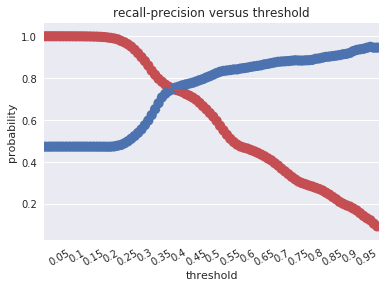

In [98]:
ax = sns.pointplot(x = [element[0] for element in recall_precision_lr], y=[element[1] for element in recall_precision_lr], color="r", label='0s')
ax = sns.pointplot(x = [element[0] for element in recall_precision_lr], y=[element[2] for element in recall_precision_lr], color="b", label='0s')

ax.set_title('recall-precision versus threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('probability')


labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%5 == 0) or (i%5 ==1) or (i%5 == 2) or (i%5 == 3): labels[i] = '' # skip even labels
ax.set_xticklabels(labels, rotation=30)
plt.show()

* calculamos el punto de intersección

In [99]:
idx = np.argwhere(np.diff(np.sign(np.asarray([element[1] for element in recall_precision_lr]) - np.asarray([element[2] for element in recall_precision_lr]))) != 0).reshape(-1) + 0
idx = idx[0]

chosen_threshold = [element[0] for element in recall_precision_lr][idx]
chosen_threshold

0.38

* veamos el nuevo valor de 'recall' y de la 'precision' para este punto escogido

In [100]:
recall_lr = [element[1] for element in recall_precision_lr][idx]
print(recall_lr)

precision_lr = [element[-1] for element in recall_precision_lr][idx]
print(precision_lr)

0.75006461618
0.747456535737


* ¿Qué pinta tiene la nueva matriz de confusión?

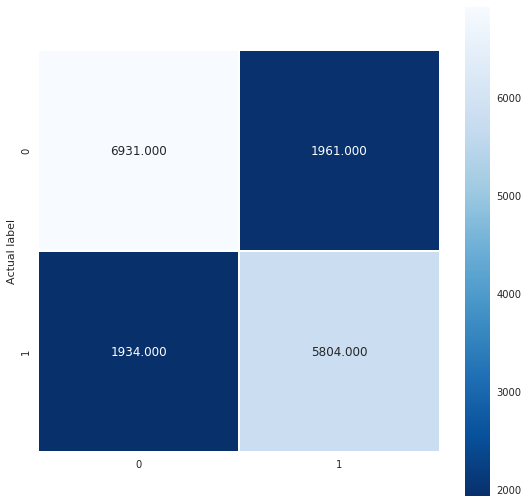

In [101]:
final_predictions_lr = [1 if value > chosen_threshold else 0 for value in prob_predictions1]

cm_lr = confusion_matrix(y_test, final_predictions_lr)
plt.figure(figsize=(9,9))
sns.heatmap(cm_lr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

* pintamos la curva ROC y calculamos el AUC

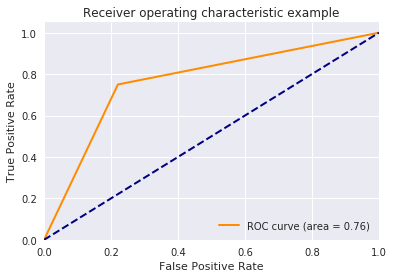

In [102]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, final_predictions_lr)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC media y el AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, final_predictions_lr)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
auc_lr = roc_auc["micro"]
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* Almacenamos resultados en lista 'final_results'

In [103]:
final_results.append((recall_lr, precision_lr, auc_lr))

### Random Forest

* otra manera de probar distintas combinaciones para mejorar los resultados es mediante un gridSearch

In [ ]:
AQUI

In [105]:
rf = RandomForestClassifier(random_state= seed_value)

param_grid = {'criterion':('gini', 'entropy'), 'max_features':['auto', 'log2'], 'n_estimators':[50,100]}
scoring = {'recall':make_scorer(recall_score)}
cross_val_rf = GridSearchCV(rf, param_grid, scoring=make_scorer(recall_score), cv = 3)
cross_val_rf.fit(X_train,y_train)

predictions_rf = cross_val_rf.predict(X_test)
prob_predictions_rf = cross_val_rf.predict_proba(X_test)
cm_rf = confusion_matrix(y_test, predictions_rf)

recall_rf = recall_score(y_test, predictions_rf)
precision_rf = precision_score(y_test, predictions_rf)

recall_rf

0.710777978805893

* Pintamos matriz de confusión

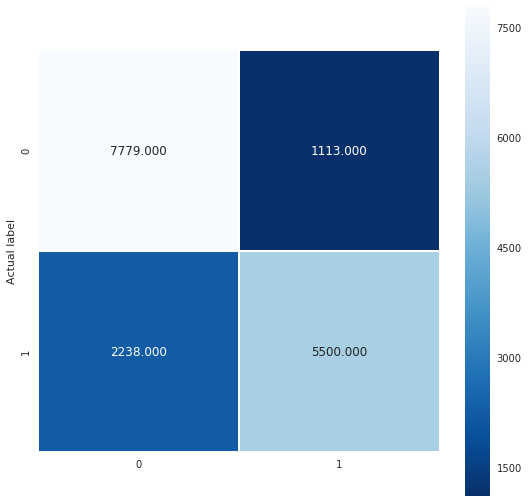

In [106]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

* Al hacer el predict lo hace con el mejor modelo. No obstante, recuperemos qué valores retornan un mayor recall:

In [107]:
best_result_rf = cross_val_rf.best_params_

(print("El mejor random forest tiene un criterio de corte de {0}, un valor de max_features de {1} y n_estimators de {2}"
       .format(best_result_rf['criterion'], best_result_rf['max_features'], best_result_rf['n_estimators'])))

El mejor random forest tiene un criterio de corte de gini, un valor de max_features de auto y n_estimators de 100


* Calculemos ahora su curva ROC y AUC

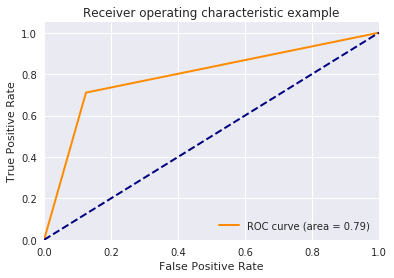

In [108]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions_rf)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC media y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, predictions_rf)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
auc_rf = roc_auc['micro']
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* Añadimos resultados a la lista 'final_results'

In [109]:
final_results.append((recall_rf, precision_rf, auc_rf))

### GBTrees

In [110]:
gbt = GradientBoostingClassifier(random_state= seed_value)


param_grid = {'loss':('deviance', 'exponential'), 'n_estimators':[100,150], 'max_depth':[2,3]}
scoring = {'recall':make_scorer(recall_score)}
cross_val_gbt = GridSearchCV(gbt, param_grid, scoring=make_scorer(recall_score), cv = 3)

cross_val_gbt.fit(X_train,y_train)

predictions_gbt = cross_val_gbt.predict(X_test)
prob_predictions_gbt = cross_val_gbt.predict_proba(X_test)
cm_gbt = confusion_matrix(y_test, predictions_gbt)

recall_gbt = recall_score(y_test, predictions_gbt)
precision_gbt = precision_score(y_test, predictions_gbt)

recall_gbt

0.72292582062548461

* Pintamos matriz de confusión

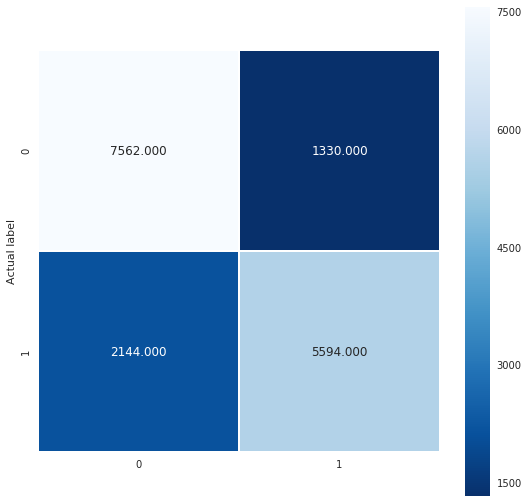

In [111]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

* Al hacer el predict lo hace con el mejor modelo. No obstante, recuperemos qué valores retornan un mayor recall:

In [112]:
best_result_gbt = cross_val_gbt.best_params_

(print("El mejor GBT tiene un criterio de loss de {0}, n_estimators de {1} y una max_depth de {2}"
       .format(best_result_gbt['loss'], best_result_gbt['n_estimators'], best_result_gbt['max_depth'])))

El mejor GBT tiene un criterio de loss de exponential, n_estimators de 100 y una max_depth de 2


* Calculemos su curva ROC y AUC

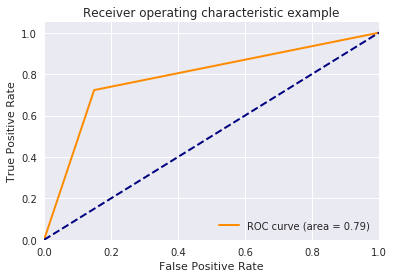

In [113]:
# Calcular la curva ROC y el área ROC de cada una de las clases
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions_gbt)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC media y el AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, predictions_gbt)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
auc_gbt = roc_auc['micro']

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* Añadimos estos resultados a 'final_results'

In [114]:
final_results.append((recall_gbt, precision_gbt, auc_gbt))

* Creamos dataframe con los resultados de los distintos algoritmos y ordenamos de mayor a menor recall

In [115]:
algorithm_df = (pd.DataFrame(data = final_results, index = ['logistic_regression', 'random_forest', 'gbt'],
                             columns = ['recall', 'precision', 'auc']))

algorithm_df = algorithm_df.sort_values('recall', ascending=False)

algorithm_df

,recall,precision,auc
logistic_regression,0.750065,0.747457,0.764765
gbt,0.722926,0.807915,0.786677
random_forest,0.710778,0.831695,0.792805


### Parece ser que el Random Forest es el mejor modelo

¿Y si, dados los mejores modelos para random forest y gbt, también calculamos el punto de corte entre recall y precisión para elegir umbral? 

#### RandomForest: jugamos con el threshold

In [116]:
prob_predictions1_rf = [element[1] for element in prob_predictions_rf]

recall_precision_rf = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value > threshold else 0 for value in prob_predictions1_rf]
    recall_precision_rf.append([threshold, recall_score(y_test, given_threshold), precision_score(y_test, given_threshold)])

recall_precision_rf

[[0.01, 0.9998707676402171, 0.46704092720028972],
 [0.02, 0.9998707676402171, 0.4687386404943657],
 [0.029999999999999999, 0.9998707676402171, 0.47042013741107802],
 [0.040000000000000001, 0.99948307056086849, 0.47273838630806847],
 [0.050000000000000003, 0.99831997932282246, 0.47465437788018433],
 [0.060000000000000005, 0.99715688808477643, 0.47747524752475246],
 [0.069999999999999993, 0.99715688808477643, 0.47747524752475246],
 [0.080000000000000002, 0.99263375549237531, 0.48378157082572276],
 [0.089999999999999997, 0.99056603773584906, 0.48803005220934675],
 [0.099999999999999992, 0.99056603773584906, 0.48803005220934675],
 [0.11, 0.9844921168260532, 0.49846234378067134],
 [0.12, 0.97945205479452058, 0.50322023770001989],
 [0.13, 0.97389506332385634, 0.50932684509326842],
 [0.14000000000000001, 0.96833807185319198, 0.51611792257886757],
 [0.15000000000000002, 0.96368570690100797, 0.52454980303882948],
 [0.16, 0.95903334194882395, 0.53296466532605569],
 [0.17000000000000001, 0.952442

* gráfica con resutlados de recall-precision

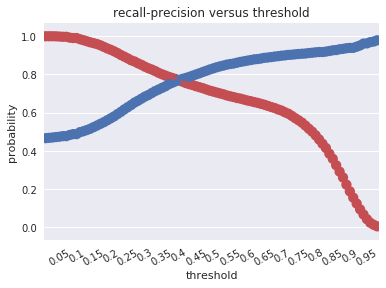

In [117]:
ax = sns.pointplot(x = [element[0] for element in recall_precision_rf], y=[element[1] for element in recall_precision_rf], color="r", label='0s')
ax = sns.pointplot(x = [element[0] for element in recall_precision_rf], y=[element[2] for element in recall_precision_rf], color="b", label='0s')

ax.set_title('recall-precision versus threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('probability')


labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%5 == 0) or (i%5 ==1) or (i%5 == 2) or (i%5 == 3): labels[i] = '' # skip even labels
ax.set_xticklabels(labels, rotation=30) #

* calculamos punto de intersección

In [118]:
idx = np.argwhere(np.diff(np.sign(np.asarray([element[1] for element in recall_precision_rf]) - np.asarray([element[2] for element in recall_precision_rf]))) != 0).reshape(-1) + 0
idx = idx[0]

chosen_threshold_rf = [element[0] for element in recall_precision_rf][idx]
chosen_threshold_rf

0.39000000000000001

* veamos nuevos valores de recall y precision con este umbral

In [119]:
recall_rf = [element[1] for element in recall_precision_rf][idx]
print(recall_rf)

precision_lr = [element[-1] for element in recall_precision_rf][idx]
print(precision_rf)

0.776428017576
0.831695145925


* recalculamos AUC

In [120]:
final_predictions_rf = [1 if value > chosen_threshold_rf else 0 for value in prob_predictions1_rf]


n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, final_predictions_rf)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC media y el AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, final_predictions_rf)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
auc_rf = roc_auc['micro']

* Añadimos valores a 'final_results'

In [121]:
final_results.append((recall_rf, precision_rf, auc_rf))

#### GBT: jugamos con el threshold

In [122]:
prob_predictions1_gbt = [element[1] for element in prob_predictions_gbt]

recall_precision_gbt = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value > threshold else 0 for value in prob_predictions1_gbt]
    recall_precision_gbt.append([threshold, recall_score(y_test, given_threshold), precision_score(y_test, given_threshold)])

recall_precision_gbt

[[0.01, 1.0, 0.47045233463035019],
 [0.02, 1.0, 0.47226121452548064],
 [0.029999999999999999, 1.0, 0.47257847807499692],
 [0.040000000000000001, 1.0, 0.47283837457989614],
 [0.050000000000000003, 1.0, 0.47289616818431829],
 [0.060000000000000005, 1.0, 0.47298288508557457],
 [0.069999999999999993, 1.0, 0.47298288508557457],
 [0.080000000000000002, 1.0, 0.47298288508557457],
 [0.089999999999999997, 1.0, 0.47298288508557457],
 [0.099999999999999992, 1.0, 0.4730117977871508],
 [0.11, 1.0, 0.4730117977871508],
 [0.12, 1.0, 0.47306963379592837],
 [0.13, 0.9998707676402171, 0.47341369393624183],
 [0.14000000000000001, 0.99896614112173687, 0.4751659700024588],
 [0.15000000000000002, 0.99444300852933576, 0.48259642521166513],
 [0.16, 0.98475058154561901, 0.49712943632567852],
 [0.17000000000000001, 0.97699663995864561, 0.50796210441443257],
 [0.18000000000000002, 0.97014732489015254, 0.51566149196318178],
 [0.19, 0.96471956577927109, 0.52385964912280703],
 [0.20000000000000001, 0.95709485655208

* gráfica con resultados de recall-precision

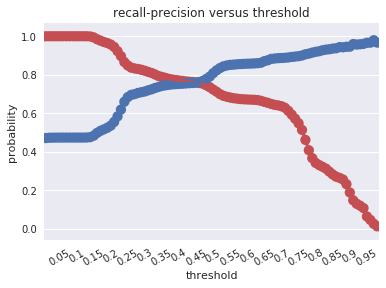

In [123]:
ax = sns.pointplot(x = [element[0] for element in recall_precision_gbt], y=[element[1] for element in recall_precision_gbt], color="r", label='0s')
ax = sns.pointplot(x = [element[0] for element in recall_precision_gbt], y=[element[2] for element in recall_precision_gbt], color="b", label='0s')

ax.set_title('recall-precision versus threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('probability')


labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%5 == 0) or (i%5 ==1) or (i%5 == 2) or (i%5 == 3): labels[i] = '' # skip even labels
ax.set_xticklabels(labels, rotation=30) #

* calculamos punto de intersección

In [124]:
idx = np.argwhere(np.diff(np.sign(np.asarray([element[1] for element in recall_precision_gbt]) - np.asarray([element[2] for element in recall_precision_gbt]))) != 0).reshape(-1) + 0
idx = idx[0]

chosen_threshold_gbt = [element[0] for element in recall_precision_gbt][idx]
chosen_threshold_gbt

0.45000000000000001

* veamos nuevos valores de recall y precision con este umbral

In [125]:
recall_gbt = [element[1] for element in recall_precision_gbt][idx]
print(recall_gbt)

precision_gbt = [element[-1] for element in recall_precision_gbt][idx]
print(precision_gbt)

0.760015507883
0.758740807638


* recalculamos AUC

In [126]:
final_predictions_gbt = [1 if value > chosen_threshold_gbt else 0 for value in prob_predictions1_gbt]


n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, final_predictions_gbt)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC media y el AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, final_predictions_gbt)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
auc_gbt = roc_auc['micro']

* Añadimos valores a final_results

In [127]:
final_results.append((recall_gbt, precision_gbt, auc_gbt))

* Volvemos a crear dataframe para ver los resutlados

In [128]:
results_df = (pd.DataFrame(data = final_results, columns = ['recall', 'precision', 'auc'],
                          index = ['logistic_regression', 'random_forest', 'gbt', 'random_forest_threshold', 'gbt_threshold']))

results_df = results_df.sort_values('recall', ascending=False)

results_df

,recall,precision,auc
random_forest_threshold,0.776428,0.831695,0.783963
gbt_threshold,0.760016,0.758741,0.774857
logistic_regression,0.750065,0.747457,0.764765
gbt,0.722926,0.807915,0.786677
random_forest,0.710778,0.831695,0.792805


### Tras este nuevo tuneo gana el Random Forest! Hagamos un resumen del modelo que tenemos

In [129]:
best_result_rf = cross_val_rf.best_params_

(print("El mejor random forest tiene un criterio de corte de {0}, un valor de max_features de {1} n_estimators de {2} y un umbral de {3}"
       .format(best_result_rf['criterion'], best_result_rf['max_features'], best_result_rf['n_estimators'], chosen_threshold_rf)))

El mejor random forest tiene un criterio de corte de gini, un valor de max_features de auto n_estimators de 100 y un umbral de 0.39


## Ahora toca hacer un clustering de aquellos que realmente han sido readmitidos

* todas las variables entrarán excepto las de 'not_input'. Creemos vector con ellas

In [130]:
variables_clustering = [element for element in diabetes_1.columns if element not in not_input]

* haremos un K-Means: el primer paso será determinar el valor de K por el método del codo

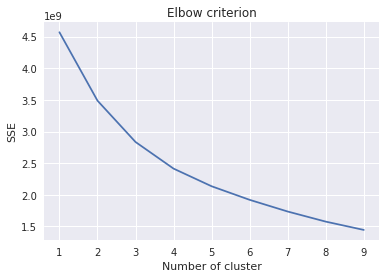

In [131]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(diabetes_1[variables_clustering])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Elbow criterion")
plt.show()

* de la gráfica se aprecia que el mejor valor sería k=4: hacemos un K-Means para k = 4

In [132]:
kmeans4 = KMeans(n_clusters=4, random_state= seed_value)

kmeans4.fit(diabetes_1[variables_clustering])

diabetes_1['labels_4'] = kmeans4.labels_
print(kmeans4.labels_)
print(kmeans4.cluster_centers_)

[0 0 0 ..., 3 0 0]
[[  6.16024238e+00   4.42125344e+00   4.40309151e+01   1.27587948e+00
    1.60387701e+01   4.12220165e-01   2.94619312e-01   9.44678225e-01
    4.01796434e+02   3.47755661e+02   3.27243797e+02   7.60438759e+00
    1.66077540e-02   3.55439601e-01   3.77097009e-01   4.34831398e-02
    1.73932559e-02   7.85501880e-04   1.19789037e-01   2.81490209e-01
    2.10795040e-01   1.49301464e-01   1.30561634e-01   7.57448241e-03
    9.53823711e-04   2.24429108e-04   1.12236997e+00   1.64955395e-02
    4.96100544e-01   8.11030691e-01   2.03220558e-01   4.65690400e-03
    7.67771980e-01   1.31291028e-02   1.12214554e-02   5.39639791e-01
    4.60360209e-01   9.20159345e-03   2.24429108e-04   6.78112551e-01
    0.00000000e+00   9.53823711e-04   0.00000000e+00   2.66621781e-01
    0.00000000e+00   2.39578073e-02   6.95730236e-03   0.00000000e+00
    1.38023902e-02   1.12214554e-04   5.61072771e-05   1.69107333e-01
    6.26662178e-01   5.61072771e-05   0.00000000e+00   2.04174381e-01
 

/home/eduardo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


* estudiamos en qué cantidad se reparten los readmitidos en estos 4 clusters

In [133]:
num_1s = len(diabetes_1)

cluster_study = diabetes_1.groupby('labels_4').count()['encounter_id'].reset_index().rename(columns={'encounter_id':'count'})

cluster_study['count_percent'] = cluster_study['count']*100/num_1s

cluster_study

,labels_4,count,count_percent
0,0,17824,46.068752
1,1,8197,21.186353
2,2,6425,16.606358
3,3,6244,16.138537


* estudiamos los cluster centers para saber las variables más importantes en cada cluster

In [134]:
cluster_centers = kmeans4.cluster_centers_.tolist()

* variable a variable calculamos la mediana

In [135]:
cluster_centers_medians = []

for index in range(len(cluster_centers[0])):
    temp = []
    for element in cluster_centers:
        temp.append(element[index])
    cluster_centers_medians.append(np.median(temp))
        

* A cada elemento le restamos el valor de la mediana y divimos su valor absoluto por la mediana: así veremos cuánto se aleja. 

In [136]:
cluster_centers_standardized = []
for element in cluster_centers:
    temp = []
    for index in range(len(cluster_centers_medians)):
        temp.append((index, (abs(element[index]-cluster_centers_medians[index]))/cluster_centers_medians[index]))
    cluster_centers_standardized.append(temp) 
    
    

/home/eduardo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


* Eliminamos nulos en caso que hayan aparecido

In [137]:
for index, element in enumerate(cluster_centers_standardized):
    cluster_centers_standardized[index] = [value for value in element if not np.isnan(value[1])]

* Ordenamos de mayor en menor valores para quedarnos con las variables más importantes por cluster

In [138]:
for index, element in enumerate(cluster_centers_standardized):
    cluster_centers_standardized[index] = [sorted(cluster_centers_standardized[index], key=lambda value: value[-1], reverse=True)][0]

* nos quedamos con los índices de las 5 variables más importantes por cluster y lo vemos todo en un dataframe

In [139]:
for index, element in enumerate(cluster_centers_standardized):
    cluster_centers_standardized[index] = [value[0] for value in element[:5]]

* toda la información en dataframe

In [140]:
importancia_variables = pd.DataFrame(data = cluster_centers_standardized, columns=['primera_variable', 'segunda_variable', 'tercera_variable', 'cuarta_variable', 'quinta_variable'])
importancia_variables = importancia_variables.reset_index().rename(columns={'index':'cluster'})

* Cambiamos índices de variables a sus nombres

In [141]:
for element in list(importancia_variables)[1:]:
    importancia_variables[element] = importancia_variables[element].map(lambda value: variables_clustering[value])

importancia_variables

,cluster,primera_variable,segunda_variable,tercera_variable,cuarta_variable,quinta_variable
0,0,admission_source_court_law_enforcement,discharge_disposition_discharged_transferred_to_home_under_care_of_home_iv_provider,discharge_disposition_discharged_transferred_to_another_short_term_hospital,discharge_disposition_hospice___medical_facility,chlorpropamide
1,1,admission_source_court_law_enforcement,admission_type_newborn,diag_3,discharge_disposition_discharged_transferred_to_a_nursing_facility_certified_under_medicaid_but_not_certified_under_medicare_,miglitol
2,2,admission_source_transfer_from_hospital_inpt_same_fac_reslt_in_a_sep_claim,discharge_disposition_admitted_as_an_inpatient_to_this_hospital,discharge_disposition_discharged_transferred_referred_to_a_psychiatric_hospital_of_psychiatric_distinct_part_unit_of_a_hospital,admission_source_court_law_enforcement,tolazamide
3,3,admission_source_court_law_enforcement,discharge_disposition_discharged_transferred_to_another_rehab_fac_including_rehab_units_of_a_hospital__,admission_source_transfer_from_hospital_inpt_same_fac_reslt_in_a_sep_claim,discharge_disposition_admitted_as_an_inpatient_to_this_hospital,discharge_disposition_discharged_transferred_to_another_type_of_inpatient_care_institution
